In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Points_reduced_clipped.xlsx')
df[df == -9999] = np.nan
df = df.dropna()
T = (df['T1'], df['T2'], df['T3'], df['T4'], df['T5'], df['T6'], df['T7'], df['T8'], df['T9'], df['T10'], df['T11'], df['T12'])
P = (df['P1'], df['P2'], df['P3'], df['P4'], df['P5'], df['P6'], df['P7'], df['P8'], df['P9'], df['P10'], df['P11'], df['P12'])
z = df['z']

In [3]:
def Koppen(P, T, z = 0):
    if np.isnan(P).all() == True:
        classification = 'Not classified'
    else:
        data = pd.DataFrame(data = (P, T), index = ['P', 'T']).transpose()

        MAP = np.sum(P)
        MAT = np.mean(T)
        Thot = np.max(T)
        Tcold = np.min(T)
        Tmonth10 = sum(map(lambda x : x > 10, T))
        Pdry = np.min(P)
        seqT = np.array((T[0], T[1], T[2], T[3], T[4], T[5], T[6], T[7], T[8], T[9], T[10], T[11], T[0], T[1], T[2], T[3], T[4]))
        seqP = np.array((P[0], P[1], P[2], P[3], P[4], P[5], P[6], P[7], P[8], P[9], P[10], P[11], P[0], P[1], P[2], P[3], P[4]))
        data['seqT'] = np.convolve(seqT, np.ones(6, dtype=np.int), mode='valid')
        data['seqP'] = np.convolve(seqP, np.ones(6, dtype=np.int), mode='valid')

        s_st = data['seqT'].idxmax(axis = 1)
        s_f = s_st + 6
        w_st = s_f
        w_f = w_st + 6

        if s_f > 12:
            s_f = s_f - 12
        if w_f > 12:
            w_f = w_f - 12
        if s_st > 12:
            s_st = s_st - 12
        if w_st > 12:
            w_st = w_st - 12

        drymonth = data['P'].idxmin(axis = 1)
        season = []

        if s_st < s_f and w_st < w_f:
            Psdry = data['P'][(data.index >= s_st) & (data.index < s_f)].min()
            Pwdry = (data['P'][(data.index >= w_st) & (data.index < w_f)].min())
            Pswet = data['P'][(data.index >= s_st) & (data.index < s_f)].max()
            Pwwet = (data['P'][(data.index >= w_st) & (data.index < w_f)].max())
            if s_st < drymonth and s_f > drymonth:
                season.append('summer')
            else:
                season.append('winter')

        if s_st < s_f and w_st > w_f:
            Psdry = data['P'][(data.index >= s_st) & (data.index < s_f)].min()
            Pwdry = (data['P'][(data.index >= w_st)].min(), data['P'][(data.index < w_f)].min())
            Pwdry = np.min(Pwdry)
            Pswet = data['P'][(data.index >= s_st) & (data.index < s_f)].max()
            Pwwet = (data['P'][(data.index >= w_st)].max(), data['P'][(data.index < w_f)].max())
            Pwwet = np.max(Pwwet)
            if s_st < drymonth and s_f > drymonth:
                season.append('summer')
            else:
                season.append('winter')

        if s_st > s_f and w_st < w_f:
            Psdry = (data['P'][(data.index >= s_st)].min(), data['P'][(data.index < s_f)].min())
            Psdry = np.min(Psdry)
            Pwdry = (data['P'][(data.index >= w_st) & (data.index < w_f)].min())
            Pswet = (data['P'][(data.index >= s_st)].max(), data['P'][(data.index < s_f)].max())
            Pswet = np.max(Pswet)
            Pwwet = (data['P'][(data.index >= w_st) & (data.index < w_f)].max())

            if w_st < drymonth and w_f > drymonth:
                season.append('winter')
            else:
                season.append('summer')

        if s_st < w_st:
            s_f = s_f - 1
            w_f = w_f - 1
        else:
            w_f = w_f - 1
            s_f = s_f - 1

        if w_st == 12:
            w_st = 0

        if 0.7 * MAP <= data['seqP'].loc[w_st]:
            Pthresh = 2 * MAT
        elif 0.7 * MAP <= data['seqP'].loc[s_st]:
            Pthresh = 2 * MAT + 28
        else:
            Pthresh = 2 * MAT + 14

        class_Kop = []

        if z >= 2300:
            if Thot >= 0:
                class_Kop.append('HT - Tundra')
            else:
                class_Kop.append('HF - Frost or Ice Cap')
        else:
            if Thot <= 10:
                if Thot > 0:
                    class_Kop.append('ET - Tundra')
                else:
                    class_Kop.append('EF - Frost or Ice Cap')
            else:
                if MAP < 10 * Pthresh:
                    if MAP < 5 * Pthresh:
                        if MAT >= 18:
                             class_Kop.append('BWh - Hot Waste')
                        else:
                             class_Kop.append('BWk - Cold Waste')
                    else:
                        if MAT >= 18:
                             class_Kop.append('BSh - Hot Steppe')
                        else:
                             class_Kop.append('BSk - Cold Steppe')
                else:
                    if Tcold >= 18:
                        if Pdry > 60:
                            class_Kop.append('Af - Tropical Wet')
                        else:
                            if MAP < (100 - (Pdry) * 25):
                                class_Kop.append('Am - Monsoon')
                            else:
                                if season == 'summer':
                                    class_Kop.append('As - Summer Savannah')
                                else:
                                    class_Kop.append('Aw - Winter Savannah')
                    else:
                        if Tcold > -3:
                            if Pwdry > Psdry and Pwdry > Psdry * 3 and Psdry < 40:
                                class_Kop.append('Cs')
                                if Thot >= 22:
                                    class_Kop.append('a')
                                elif Thot < 22 and Tmonth10 >= 4:
                                    class_Kop.append('b')
                                else:
                                    class_Kop.append('c') 
                            elif Psdry > Pwdry and Pswet > Pwdry * 10:
                                class_Kop.append('Cw')
                                if Thot >= 22:
                                    class_Kop.append('a')
                                elif Thot < 22 and Tmonth10 >= 4:
                                    class_Kop.append('b')
                                else:
                                    class_Kop.append('c')
                            else:
                                class_Kop.append('Cf')
                                if Thot >= 22:
                                    class_Kop.append('a')
                                elif Thot < 22 and Tmonth10 >= 4:
                                    class_Kop.append('b')
                                else:
                                    class_Kop.append('c')
                        else:
                            if Pwdry > Psdry and Pwdry > Psdry * 3 and Psdry < 40:
                                class_Kop.append('Ds')
                                if Thot >= 22:
                                    class_Kop.append('a')
                                elif Thot < 22 and Tmonth10 >= 4:
                                    class_Kop.append('b')
                                elif Tmonth10 < 4 and Tcold >= -38:
                                    class_Kop.append('c')
                                else:
                                    class_Kop.append('d')
                            elif Psdry > Pwdry and Pswet > Pwdry * 10:
                                class_Kop.append('Dw')
                                if Thot >= 22:
                                    class_Kop.append('a')
                                elif Thot < 22 and Tmonth10 >= 4:
                                    class_Kop.append('b')
                                elif Tmonth10 < 4 and Tcold >= -38:
                                    class_Kop.append('c')
                                else:
                                    class_Kop.append('d')
                            else:
                                class_Kop.append('Df')
                                if Thot >= 22:
                                    class_Kop.append('a')
                                elif Thot < 22 and Tmonth10 >= 4:
                                    class_Kop.append('b')
                                elif Tmonth10 < 4 and Tcold >= -38:
                                    class_Kop.append('c')
                                else:
                                    class_Kop.append('d')
        classification = ''.join(class_Kop)
    return classification, MAP, MAT, Thot, Tcold, Tmonth10, Pdry, Psdry, Pwdry, Pswet, Pwwet, Pthresh, season, data

In [4]:
classification = []
for i in df.index:
    classification.append(Koppen((df['P1'][i], df['P2'][i], df['P3'][i], df['P4'][i], df['P5'][i], df['P6'][i], df['P7'][i], df['P8'][i], df['P9'][i], df['P10'][i], df['P11'][i], df['P12'][i]), (df['T1'][i], df['T2'][i], df['T3'][i], df['T4'][i], df['T5'][i], df['T6'][i], df['T7'][i], df['T8'][i], df['T9'][i], df['T10'][i], df['T11'][i], df['T12'][i]), df['z'][i])[0])

In [21]:
df['classification'] = np.array(classification)
df.to_excel("sample_point_results.xlsx")

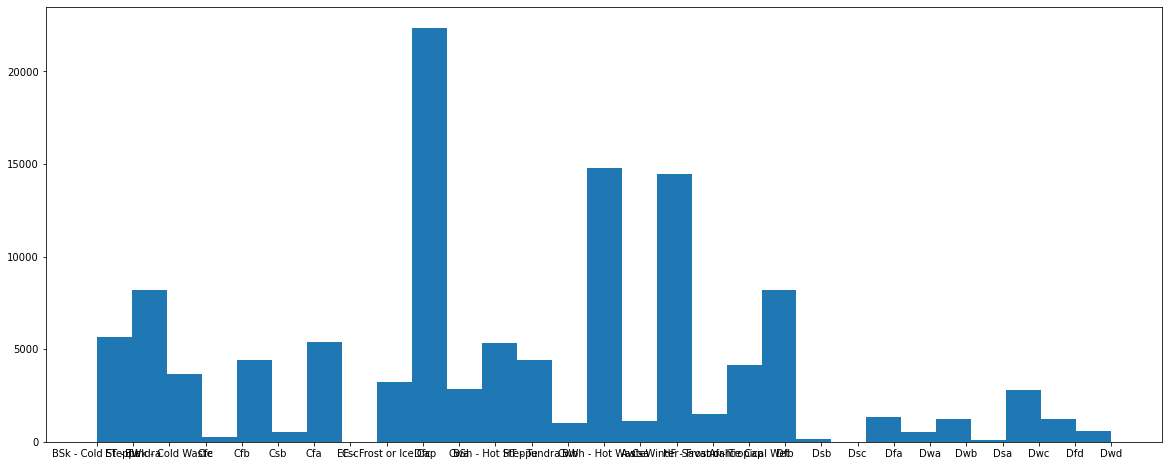

In [19]:
# plt.figure(figsize = (20, 8))
# plt.hist(df['classification'], bins = len(np.unique(df['classification'])));